In [1]:
from sage.geometry.hyperbolic_space.hyperbolic_model import moebius_transform
PD = HyperbolicPlane().PD()
UHP = HyperbolicPlane().UHP()
import numpy as np

margin_of_error = 0.001

#anti-clockwise rotation matrix of angle=angle around 0 in PD
def elliptic(angle):
    return matrix(CDF, 2, [cos(angle/2)+I*sin(angle/2),0,0,cos(angle/2)-I*sin(angle/2)])

#Möbius transformation sending 0 to point in PD
def translation(point):
    return matrix(CDF, 2, [1,point.coordinates(),np.conjugate(point.coordinates()),1])

def mobius(matrix_, point):
    return PD.get_point(moebius_transform(matrix_,point.coordinates()))

#returns true if two points are equal in PD
def checkEquality(point1, point2):
    if abs(point1.coordinates()-point2.coordinates()) < margin_of_error:
        return True

def inverse(matrix_):
    a = matrix_[0][0]
    b = matrix_[0][1]
    c = matrix_[1][0]
    d = matrix_[1][1]
    
    return matrix(CDF, 2, [d, -b, -c, a])

#a triangle is defined by its 3 vertices
class triangle:
    
    def __init__(self, vertex1, vertex2, vertex3):
        self.vertices = [vertex1, vertex2, vertex3]
        
    def getSides(self):
        vertex1 = self.vertices[0]
        vertex2 = self.vertices[1]
        vertex3 = self.vertices[2]

        side1 = PD.get_geodesic(vertex2, vertex3)
        side2 = PD.get_geodesic(vertex1, vertex3)
        side3 = PD.get_geodesic(vertex1, vertex2)
        return [side1, side2, side3]
    
    def getLengths(self):
        sides = self.getSides()
        lengths = []
        
        for side in sides:
            lengths.append(side.length())
        
        return lengths
    
    def getAngles(self):
        lengths = self.getLengths()
        length1 = lengths[0]
        length2 = lengths[1]
        length3 = lengths[2]
        
        angle1 = float(acos((cosh(length2)*cosh(length3)-cosh(length1))/(sinh(length2)*sinh(length3))))
        angle2 = float(acos((cosh(length1)*cosh(length3)-cosh(length2))/(sinh(length1)*sinh(length3))))
        angle3 = float(acos((cosh(length1)*cosh(length2)-cosh(length3))/(sinh(length1)*sinh(length2))))
        
        return [angle1, angle2, angle3]

#defines a triangle from its 3 angles, the first vertex, and the inclination of the first vertex with respect to the "horizontal"
def triangleByAngles(angle1, angle2, angle3, vertex1, inclination = 0):

        length1 = float(acosh((cos(angle1)+cos(angle2)*cos(angle3))/(sin(angle2)*sin(angle3))))
        length2 = float(acosh((cos(angle2)+cos(angle1)*cos(angle3))/(sin(angle1)*sin(angle3))))
        length3 = float(acosh((cos(angle3)+cos(angle1)*cos(angle2))/(sin(angle1)*sin(angle2))))

        translation_ = translation(vertex1)
        rotation_ = elliptic(inclination)
        
        #first, do as if vertex1 was 0 in PD
        vertex2_at_0 = mobius(rotation_,PD.get_point(tanh(length3/2)))
        #send it back to the right position
        vertex2 = mobius(translation_, vertex2_at_0)

        rotation_ = rotation_*elliptic(angle1)

        vertex3_at_0 = mobius(rotation_, PD.get_point(tanh(length2/2)))
        vertex3 = mobius(translation_, vertex3_at_0)

        return triangle(vertex1, vertex2, vertex3)

#a polygon is obtained by all the copies of firstTile obtained by rotations around the first vertex
#the orientation tells you in which direction the copies are produced (orientation=1 <-> anti-clockwise)
class polygon:
    
    def __init__(self, firstTile, orientation = 1):
        
        self.firstTile=firstTile
        self.orientation=orientation
    
    #p refers to the first angle (q,r to the second and third vertex)
    def get_p(self):
        return round(pi/(self.firstTile.getAngles()[0]))
    
    def getCenter(self):
        return self.firstTile.vertices[0]
    
    def getVertices(self):
        center = self.firstTile.vertices[0]
        
        p = self.get_p()
        
        translation_ = translation(center)
        
        #vertices are stored into two sets: all the "second vertices" and all the "third vertices"
        vertices_q=[]
        vertices_r=[]
        
        #apply all the rotations to construct the polygon
        for i in range(p):
            rotation_ = translation_ * elliptic(self.orientation*2*i*(pi/p)) * inverse(translation_)
            vertices_q.append(mobius(rotation_, self.firstTile.vertices[1]))
            vertices_r.append(mobius(rotation_, self.firstTile.vertices[2]))
        
        #a polygon has a center and two sets of peripheral vertices 
        return [center, [vertices_q, vertices_r]]
    
    #this function reflects a polygon through one of its sides
    #i is between 0 and p-1 and indicates the side
    def reflection(self, i):
        vertices = self.getVertices()
        
        #mirror is the side we want to reflect accross 
        mirror = PD.get_geodesic(vertices[1][0][i], vertices[1][1][i])
        reflection_ = mirror.reflection_involution()
        
        new_vertex1 = reflection_ * self.firstTile.vertices[0]
        new_vertex2 = reflection_ * self.firstTile.vertices[1]
        new_vertex3 = reflection_ * self.firstTile.vertices[2]
        
        new_firstTile = triangle(new_vertex1, new_vertex2, new_vertex3)
        
        return polygon(new_firstTile, -self.orientation)
    
    #draws all the sides of a polygon
    def plotSides(self):
        origin = self.getVertices()[0]
        vertices_q = self.getVertices()[1][0]
        vertices_r = self.getVertices()[1][1]
        p = self.get_p()
        
        picture = Graphics()
        
        thickness_ = .3
        
        for vertex in vertices_q:
            side = PD.get_geodesic(origin, vertex)
            picture += side.plot(False, thickness=thickness_, color='black')
        
        for vertex in vertices_r:
            side = PD.get_geodesic(origin, vertex)
            picture += side.plot(False, thickness=thickness_, color='black')
        
        for i in range(p):
            side = PD.get_geodesic(vertices_q[i], vertices_r[i])
            picture += side.plot(False, thickness=thickness_, color='black')
            
            if i < p-1:
                if self.orientation == 1:
                    side = PD.get_geodesic(vertices_q[i+1], vertices_r[i])
                else:
                    side = PD.get_geodesic(vertices_q[i], vertices_r[i-1])
                picture += side.plot(False, thickness=thickness_, color='black')
            else:
                if self.orientation == 1:
                    side = PD.get_geodesic(vertices_q[0], vertices_r[i])
                else:
                    side = PD.get_geodesic(vertices_q[i], vertices_r[p-2])
                picture += side.plot(False, thickness=thickness_, color='black')
        
        return picture

#this produces a tessallation of PD by the triangle group (p,q,r) 
#we'll assume that p is the largest, and r=2 (otherwise something will probably fail)
class tessallation:
    
    def __init__(self, p, q, r, depth):
        
        self.p = p
        self.q = q
        self.r = r
        self.depth = depth
        
        self.initialCheck()
        
    def initialCheck(self):
        if 1/self.p + 1/self.q + 1/self.r >= 1:
            print("ERROR: not hyperbolic!")
        if self.p < self.q or self.q < self.r:
            print("Please provide the parameters in decreasing order p>=q>=r")
    
    #by default, the first triangle has its p-vertex at 0 and its pq-side on the positive real axis
    def firstPolygon(self):
        return polygon(triangleByAngles(pi/self.p, pi/self.q, pi/self.r, PD.get_point(0)))
    
    #the tessalation comes into polygons at the p-vertices
    #this lists all the polgony obtained by depth-many refelections from the initial one
    #it returns a list of lists of polygons, one for each depth
    def getPolygons(self):
        polygons = []
        centers = []
        for i in range(self.depth):
            if i==0:
                firstPolygon = self.firstPolygon()
                polygons.append([firstPolygon])
                centers.append(firstPolygon.getCenter())
            else:
                newPolygons=[]
                for polygon_ in polygons[i-1]:
                    for j in range(self.p):
                        new_polygon = polygon_.reflection(j)
                        new_center = new_polygon.getCenter()
                        already_counted = False
                        
                        for center in centers:
                            already_counted = checkEquality(center, new_center)
                            if already_counted:
                                break
                                
                        if not(already_counted):
                            centers.append(new_center)
                            newPolygons.append(new_polygon)
                polygons.append(newPolygons)
        return polygons            
    
    #produces all the sides in the the tessellation, ready to be drawn
    #some of them are counted twice, which makes the peripheral sides of the polygons look thicker on the picture
    def plotMe(self):
        picture = Graphics()
        for polygons_ in self.getPolygons():
            for polygon_ in polygons_:
                picture += polygon_.plotSides()
        
        return picture   


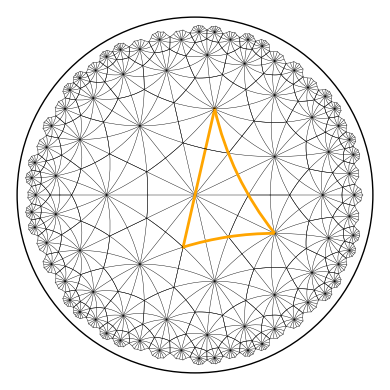

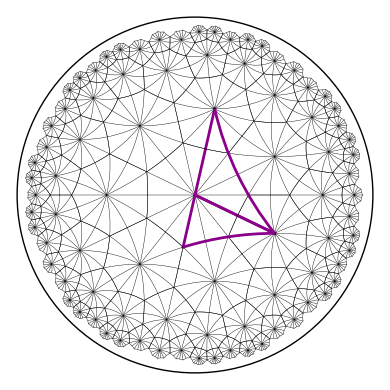

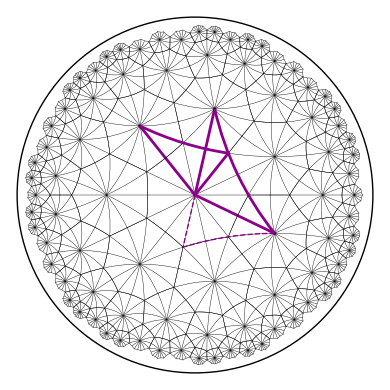

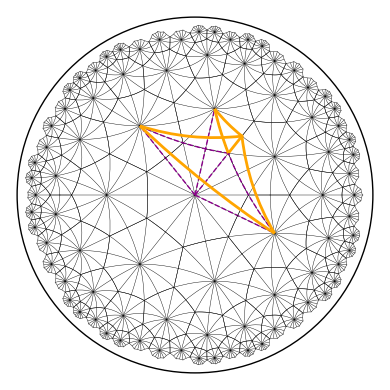

In [10]:
myTessellation=tessallation(7,3,2,depth = 4)
grid = myTessellation.plotMe()

apricot = 'orange'
mauve = 'darkmagenta'
thickness_ = 2

#Example
#triangle chain alpha=(4pi/3, 12pi/7, 12pi/7, 12pi/7), north pole 
D = myTessellation.firstPolygon().getCenter()
C1 = myTessellation.firstPolygon().getVertices()[1][0][5]
C2 = myTessellation.getPolygons()[1][1].getCenter()
C3 = myTessellation.getPolygons()[1][6].getCenter()

#B-triangle chain
####
B_triangle_chain = grid
B_triangle_chain += PD.get_geodesic(C1,C2).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain += PD.get_geodesic(C2,C3).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain += PD.get_geodesic(C1,C3).plot(True, thickness=thickness_, color=apricot)

show(B_triangle_chain) 

#D-triangle chain
####
D_triangle_chain = grid
D_triangle_chain += PD.get_geodesic(D,C2).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain += PD.get_geodesic(D,C3).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain += PD.get_geodesic(C2,C3).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain += PD.get_geodesic(D,C3).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain += PD.get_geodesic(D,C1).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain += PD.get_geodesic(C1,C3).plot(True, thickness=thickness_, color=mauve)

show(D_triangle_chain)

#apply the twist tau_2,3
C1_new = myTessellation.firstPolygon().getVertices()[1][0][1]
C4_new = myTessellation.getPolygons()[1][2].getCenter()
B_new = myTessellation.getPolygons()[1][0].getVertices()[1][1][1]

#new D-triangle chain
D_triangle_chain_new = grid
D_triangle_chain_new += PD.get_geodesic(D,C2).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(D,C3).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(C2,C3).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(D,C4_new).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(D,C1_new).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(C4_new,C1_new).plot(True, thickness=thickness_, color=mauve)

D_triangle_chain_new += PD.get_geodesic(D,C1).plot(False, linestyle="dashed", thickness=0.5*thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(C3,C1).plot(False, linestyle="dashed", thickness=0.5*thickness_, color=mauve)

show(D_triangle_chain_new)

#new B-triangle chain
B_triangle_chain_new = grid
B_triangle_chain_new += PD.get_geodesic(D,C2).plot(False, linestyle="dashed", thickness=.5*thickness_, color=mauve)
B_triangle_chain_new += PD.get_geodesic(D,C3).plot(False, linestyle="dashed", thickness=.5*thickness_, color=mauve)
B_triangle_chain_new += PD.get_geodesic(C2,C3).plot(False, linestyle="dashed", thickness=.5*thickness_, color=mauve)
B_triangle_chain_new += PD.get_geodesic(D,C4_new).plot(False, linestyle="dashed", thickness=.5*thickness_, color=mauve)
B_triangle_chain_new += PD.get_geodesic(D,C1_new).plot(False, linestyle="dashed", thickness=.5*thickness_, color=mauve)
B_triangle_chain_new += PD.get_geodesic(C4_new,C1_new).plot(False, linestyle="dashed", thickness=.5*thickness_, color=mauve)

B_triangle_chain_new += PD.get_geodesic(B_new,C1_new).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain_new += PD.get_geodesic(B_new,C2).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain_new += PD.get_geodesic(C1_new,C2).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain_new += PD.get_geodesic(B_new,C3).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain_new += PD.get_geodesic(B_new,C4_new).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain_new += PD.get_geodesic(C3,C4_new).plot(True, thickness=thickness_, color=apricot)

show(B_triangle_chain_new)

#myTriangle=triangleByAngles(pi/7, pi/3, pi/2, PD.get_point(0.7))
#myTriangle.draw()

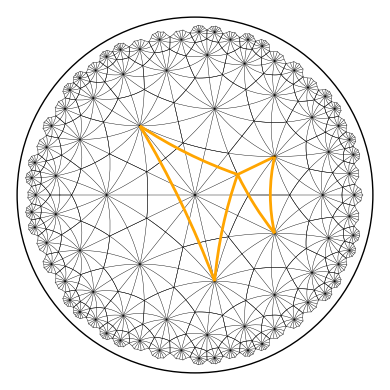

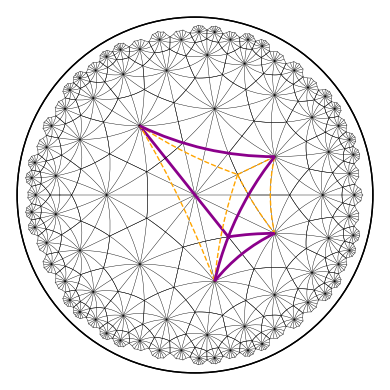

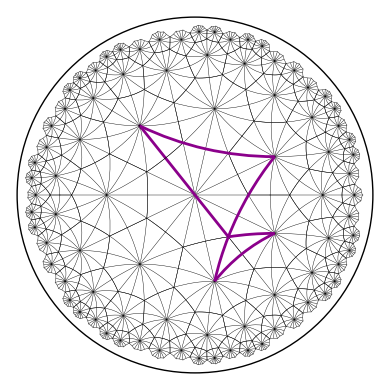

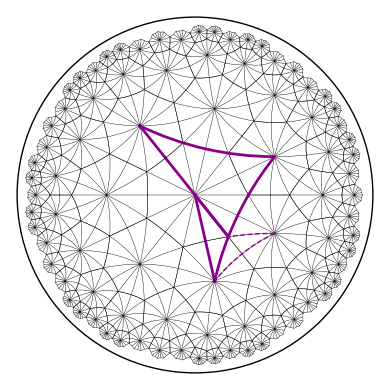

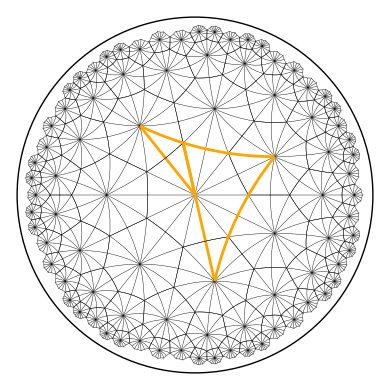

In [11]:
myTessellation=tessallation(7,3,2,depth = 4)
grid = myTessellation.plotMe()

apricot = 'orange'
mauve = 'darkmagenta'
thickness_ = 2

#Example
#triangle chain alpha=(12pi/7, 12pi/7, 10pi/7, 12pi/7), beta=pi, gamma=pi/4
B = myTessellation.firstPolygon().firstTile.vertices[2]
D = myTessellation.firstPolygon().getVertices()[1][0][6]
C1 = myTessellation.getPolygons()[1][5].getCenter()
C2 = myTessellation.getPolygons()[1][2].getCenter()
C3 = myTessellation.getPolygons()[1][0].getCenter()
C4 = myTessellation.getPolygons()[1][6].getCenter()

#B-triangle chain
####
B_triangle_chain = grid
B_triangle_chain += PD.get_geodesic(B,C3).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain += PD.get_geodesic(B,C4).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain += PD.get_geodesic(C3,C4).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain += PD.get_geodesic(B,C2).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain += PD.get_geodesic(B,C1).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain += PD.get_geodesic(C1,C2).plot(True, thickness=thickness_, color=apricot)

show(B_triangle_chain) 

#D-triangle chain
####
D_triangle_chain = grid

#old B-chain dashed
D_triangle_chain += PD.get_geodesic(B,C3).plot(False, linestyle="dashed", thickness=.5*thickness_, color=apricot)
D_triangle_chain += PD.get_geodesic(B,C4).plot(False, linestyle="dashed", thickness=.5*thickness_, color=apricot)
D_triangle_chain += PD.get_geodesic(C3,C4).plot(False, linestyle="dashed", thickness=.5*thickness_, color=apricot)
D_triangle_chain += PD.get_geodesic(B,C2).plot(False, linestyle="dashed", thickness=.5*thickness_, color=apricot)
D_triangle_chain += PD.get_geodesic(B,C1).plot(False, linestyle="dashed", thickness=.5*thickness_, color=apricot)
D_triangle_chain += PD.get_geodesic(C1,C2).plot(True, linestyle="dashed", thickness=.5*thickness_, color=apricot)

D_triangle_chain += PD.get_geodesic(D,C4).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain += PD.get_geodesic(D,C1).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain += PD.get_geodesic(C4,C1).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain += PD.get_geodesic(D,C2).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain += PD.get_geodesic(D,C3).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain += PD.get_geodesic(C2,C3).plot(True, thickness=thickness_, color=mauve)

show(D_triangle_chain)

#D-triangle chain without shadow of B-triangle chain
####
D_triangle_chain_no_shadow = grid

D_triangle_chain_no_shadow += PD.get_geodesic(D,C4).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_no_shadow += PD.get_geodesic(D,C1).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_no_shadow += PD.get_geodesic(C4,C1).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_no_shadow += PD.get_geodesic(D,C2).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_no_shadow += PD.get_geodesic(D,C3).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_no_shadow += PD.get_geodesic(C2,C3).plot(True, thickness=thickness_, color=mauve)

show(D_triangle_chain_no_shadow)

#apply the twist tau_2,3
C1_new = myTessellation.firstPolygon().getCenter()
C4_new = C1
B_new = myTessellation.firstPolygon().getVertices()[1][0][2]

#new D-triangle chain
D_triangle_chain_new = grid
D_triangle_chain_new += PD.get_geodesic(D,C2).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(D,C3).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(C2,C3).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(D,C4_new).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(D,C1_new).plot(False, thickness=thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(C4_new,C1_new).plot(True, thickness=thickness_, color=mauve)

D_triangle_chain_new += PD.get_geodesic(D,C4).plot(False, linestyle="dashed", thickness=0.5*thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(D,C1).plot(False, linestyle="dashed", thickness=0.5*thickness_, color=mauve)
D_triangle_chain_new += PD.get_geodesic(C4,C1).plot(False, linestyle="dashed", thickness=0.5*thickness_, color=mauve)

show(D_triangle_chain_new)

#new B-triangle chain
B_triangle_chain_new = grid
B_triangle_chain_new += PD.get_geodesic(B_new,C1_new).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain_new += PD.get_geodesic(B_new,C2).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain_new += PD.get_geodesic(C1_new,C2).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain_new += PD.get_geodesic(B_new,C3).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain_new += PD.get_geodesic(B_new,C4_new).plot(False, thickness=thickness_, color=apricot)
B_triangle_chain_new += PD.get_geodesic(C3,C4_new).plot(True, thickness=thickness_, color=apricot)

show(B_triangle_chain_new)

#myTriangle=triangleByAngles(pi/7, pi/3, pi/2, PD.get_point(0.7))
#myTriangle.draw()